# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

### Upload Data Files

Upload the following files into the `data` folder:

- `train-claims.json`
- `dev-claims.json`
- `test-claims-unlabelled.json`
- `evidence.json`
- `evidence_32809.json` (generated by running `DataSet Processing2_Faiss.ipynb`)

The following script will generate `dev-claims.json` and `train-claims.json` with embedded representations. These files are smaller than 5MB and will also be stored in the `local_data/train_embed` directory.

### Upload Code Files

Open the `Sim_tools` folder and drag all the files into your Colab workspace. These scripts are required for SimCSE training, embedding, and evaluation:

- `dataset_Sim.py`
- `embed_evidence.py`
- `eval_train.py`
- `model_Sim.py`
- `train_classifier.py`
- `train_Sim.py`

### Upload Model Checkpoint

Upload the following trained model file into the `saved_model` folder:

- `best_model_bt.pt`

### Training Data Generation

The training data is constructed for supervised SimCSE learning. Each training sample consists of an anchor sentence (claim), a positive sentence (relevant evidence), and a negative sentence (irrelevant evidence). These triplets are saved in a CSV file with the following format:

- `anchor`: a claim statement
- `positive`: an evidence sentence labeled as relevant to the claim
- `negative`: an evidence sentence not related to the claim

This structure enables the model to learn fine-grained semantic similarities by contrasting positive and negative examples relative to the anchor.

In [1]:
!pip install loguru


In [1]:
import json
import csv
import random
import os

# Create 'log' and 'data' directories if they don't exist
os.makedirs('log', exist_ok=True)
os.makedirs('data', exist_ok=True)

In [2]:
train_json_path = "data/train-claims.json"      # claim & evidence
dev_json_path = "data/dev-claims.json"      # claim & evidence
test_json_path = "data/test-claims-unlabelled.json"  # claim
evidence_json_path = "data/evidence.json"  # evidence
output_evidence_set_path = "data/evidence_subset_train.json"
output_claim_set_path = "data/claims.json"

# output_dev_emb_path = "local_data/dev-embed-1.json"

with open(train_json_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(dev_json_path, "r", encoding="utf-8") as f:
    dev_data = json.load(f)
with open(test_json_path, "r", encoding="utf-8") as f:
    test_data = json.load(f)
with open(evidence_json_path, "r", encoding="utf-8") as f:
    evidence_data = json.load(f)

#combine train and dev data
# merged_data = {**train_data, **dev_data}
merged_data = train_data

evicence_set = {}
for claim_id, claim_info in merged_data.items():

    claim_text = claim_info["claim_text"]
    positive_ids = claim_info["evidences"]

    for pos_id in positive_ids:
        if pos_id not in evidence_data:
            print(f"Warning: Evidence ID {pos_id} not found in evidence data.")
            continue
        evicence_set[pos_id] = evidence_data[pos_id]

print(len(evicence_set))
# Save the evidence set to a JSON file
with open(output_evidence_set_path, "w", encoding="utf-8") as f:
    json.dump(evicence_set, f, ensure_ascii=False, indent=4)


claim_set = {}

def get_claims(data):

    claim_set = {}
    for claim_id, claim_info in data.items():
        claim_text = claim_info["claim_text"]
        claim_set[claim_id] = {
            "claim_text": claim_text,
        }
    return claim_set

train_claim_set = get_claims(train_data)
dev_claim_set = get_claims(dev_data)
test_claim_set = get_claims(test_data)
claim_set = {**train_claim_set, **dev_claim_set, **test_claim_set}
print(len(claim_set))
# Save the claim set to a JSON file
with open(output_claim_set_path, "w", encoding="utf-8") as f:
    json.dump(claim_set, f, ensure_ascii=False, indent=4)

3121
1535


In [3]:
import json
import csv
import random

train_json_path = "data/train-claims.json"      # claim & evidence
evidence_json_path = "data/evidence_32809.json"  # evidence
output_csv_path = "data/train-embed.csv"     # output csv path
output_csv_path2 = "data/dev-embed.csv"
with open(train_json_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)

with open(evidence_json_path, "r", encoding="utf-8") as f:
    evidence_data = json.load(f)

all_evidence_ids = list(evidence_data.keys())

triplets = []
count = 0
for claim_id, claim_info in train_data.items():

    claim_text = claim_info["claim_text"]
    positive_ids = claim_info["evidences"]

    for pos_id in positive_ids:
        if pos_id not in evidence_data:
            continue
        pos_text = evidence_data[pos_id]

        negative_candidates = [eid for eid in all_evidence_ids if eid not in positive_ids]
        for _ in range(2):
            neg_id = random.choice(negative_candidates)
            neg_text = evidence_data[neg_id]

            triplets.append((claim_text, pos_text, neg_text))
    # print(f'processing claim_id: {claim_id} {count}/{len(train_data)}', {(claim_text, pos_text, neg_text)})
    count += 1


random.shuffle(triplets)
split_idx = int(len(triplets) * 0.8)
train_triplets = triplets[:split_idx]
dev_triplets = triplets[split_idx:]

with open(output_csv_path, "w", newline='', encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["sent0", "sent1", "hard_neg"])
    writer.writerows(train_triplets)

with open(output_csv_path2, "w", newline='', encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["sent0", "sent1", "hard_neg"])
    writer.writerows(dev_triplets)

print(f"saved train triplets to {output_csv_path}")
print(f"saved dev triplets to {output_csv_path2}")
print(f'genrate train triplets: {len(train_triplets)}')
print(f'genrate dev triplets: {len(dev_triplets)}')


saved train triplets to data/train-embed.csv
saved dev triplets to data/dev-embed.csv
genrate train triplets: 6595
genrate dev triplets: 1649


In [4]:
from dataset_Sim import TrainDataset, TestDataset, ClaimEvidenceEmbeddingDataset
from embed_evidence import embed_evidence, embed_evidence_pkl, load_evidence_embeddings_from_pickle
from model_Sim import SimcseModel, simcse_sup_loss, ClaimEvidenceClassifier
from train_Sim import load_train_data_supervised, train_sup, load_test_data_supervised
from embed_evidence import embed_evidence
from eval_train import match_evidence_by_similarity, varify_evidence
# from train_classifier import train_classifier

import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import BertModel, BertConfig, BertTokenizer
from loguru import logger
from tqdm import tqdm

### load saved model

In [5]:
batch_size = 16
max_length = 256
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

print(f"Using device: {device}")
checkpoint = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = SimcseModel(pretrained_model=checkpoint, pooling='pooler', dropout=0.1).to(device)
model.load_state_dict(torch.load("best_model_bt.pt", map_location=device))
model.eval()

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


SimcseModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

### Model Training

In [6]:
batch_size = 16
max_length = 256
file_path = 'data/train-embed.csv'
dev_file_path = 'data/dev-embed.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = SimcseModel(pretrained_model=checkpoint, pooling='pooler', dropout=0.1).to(device)
# model.load_state_dict(torch.load("best_model.pt", map_location=device))
train_data = load_train_data_supervised(tokenizer, file_path, max_length)
train_dataset = TrainDataset(train_data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)

dev_data = load_test_data_supervised(tokenizer, dev_file_path, max_length)
dev_dataset = TestDataset(dev_data, tokenizer)
dev_dataloader = DataLoader(dev_dataset, batch_size, shuffle=False, num_workers=2)

optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-5)


In [ ]:
import time
cur_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
logger.add('log/train-{}.log'.format(cur_time))

1

In [ ]:
train_loss_log, eval_loss_log, accuracy_log, f1_log = train_sup(model,
          train_dataloader,
          dev_dataloader,
          optimizer,
          device,
          tokenizer,
          epochs = 5,
          eval_step = 300, train_mode = 'supervise',
          dev_claim_path = 'data/dev-claims.json',
          evidence_subset_path = 'data/evidence_subset_train.json',
          output_pkl_path = 'evidence_embeddings.pkl')

2025-05-18 02:22:10.909 | INFO     | train_Sim:train_sup:72 - start training


Save: total 3121 evidence save to evidence_embeddings.pkl


2025-05-18 02:22:51.418 | INFO     | train_Sim:eval_accuracy:199 - Load evidence embeddings from evidence_embeddings.pkl
2025-05-18 02:22:54.206 | INFO     | train_Sim:eval_accuracy:241 - [Eval Accuracy] Recall: 0.0061, Precision: 0.0019, F1: 0.0030
2025-05-18 02:22:54.207 | INFO     | train_Sim:eval_accuracy:242 - [Eval Accuracy] Average number of evidence with sim > 0.5: 0.9648
2025-05-18 02:22:54.213 | INFO     | train_Sim:train_sup:88 - Step 0 retrieval_accuracy: 0.0061
2025-05-18 02:22:54.214 | INFO     | train_Sim:train_sup:89 - Step 0 f1_score: 0.0030
100%|██████████| 155/155 [01:43<00:00,  1.50it/s]
2025-05-18 02:24:39.580 | INFO     | train_Sim:train_sup:120 - epoch: 0, step: 0, eval_loss: 0.6935
2025-05-18 02:24:45.792 | INFO     | train_Sim:train_sup:125 - Best model saved at step 0 with loss 0.6935
100%|██████████| 155/155 [01:45<00:00,  1.47it/s]
2025-05-18 02:35:55.902 | INFO     | train_Sim:train_sup:120 - epoch: 0, step: 300, eval_loss: 0.5589
2025-05-18 02:36:02.591 | 

Save: total 3121 evidence save to evidence_embeddings.pkl


2025-05-18 02:48:36.553 | INFO     | train_Sim:eval_accuracy:199 - Load evidence embeddings from evidence_embeddings.pkl
2025-05-18 02:48:39.168 | INFO     | train_Sim:eval_accuracy:241 - [Eval Accuracy] Recall: 0.0692, Precision: 0.0221, F1: 0.0335
2025-05-18 02:48:39.169 | INFO     | train_Sim:eval_accuracy:242 - [Eval Accuracy] Average number of evidence with sim > 0.5: 0.5516
2025-05-18 02:48:39.177 | INFO     | train_Sim:train_sup:130 - epoch: 0, step: 618, retrieval_accuracy: 0.0692
2025-05-18 02:48:39.177 | INFO     | train_Sim:train_sup:131 - epoch: 0, step: 618, f1_score: 0.0335
2025-05-18 02:48:41.578 | INFO     | train_Sim:train_sup:135 - Best model saved at step 618 with accuracy 0.0692
100%|██████████| 155/155 [01:45<00:00,  1.47it/s]
2025-05-18 02:59:17.586 | INFO     | train_Sim:train_sup:120 - epoch: 1, step: 900, eval_loss: 0.4792
2025-05-18 02:59:23.504 | INFO     | train_Sim:train_sup:125 - Best model saved at step 900 with loss 0.4792
100%|██████████| 155/155 [01:45

Save: total 3121 evidence save to evidence_embeddings.pkl


2025-05-18 03:12:30.996 | INFO     | train_Sim:eval_accuracy:199 - Load evidence embeddings from evidence_embeddings.pkl
2025-05-18 03:12:33.630 | INFO     | train_Sim:eval_accuracy:241 - [Eval Accuracy] Recall: 0.0896, Precision: 0.0286, F1: 0.0433
2025-05-18 03:12:33.631 | INFO     | train_Sim:eval_accuracy:242 - [Eval Accuracy] Average number of evidence with sim > 0.5: 0.3677
2025-05-18 03:12:33.641 | INFO     | train_Sim:train_sup:130 - epoch: 1, step: 1237, retrieval_accuracy: 0.0896
2025-05-18 03:12:33.641 | INFO     | train_Sim:train_sup:131 - epoch: 1, step: 1237, f1_score: 0.0433
2025-05-18 03:12:36.415 | INFO     | train_Sim:train_sup:135 - Best model saved at step 1237 with accuracy 0.0896
2025-05-18 03:12:36.417 | INFO     | train_Sim:train_sup:141 - Training completed. Best loss: 0.4673


In [ ]:
import pandas as pd

df_train = pd.DataFrame(train_loss_log, columns=['step', 'train_loss'])
df_eval  = pd.DataFrame(eval_loss_log, columns=['step', 'eval_loss'])
df_acc   = pd.DataFrame(accuracy_log, columns=['step', 'accuracy'])
df_f1    = pd.DataFrame(f1_log, columns=['step', 'f1_score'])

log_df = pd.merge(df_train, df_eval, on='step', how='outer')
log_df = pd.merge(log_df, df_acc, on='step', how='outer')
log_df = pd.merge(log_df, df_f1, on='step', how='outer')

log_df.sort_values(by='step', inplace=True)

log_df.to_csv("log/training_log.csv", index=False)


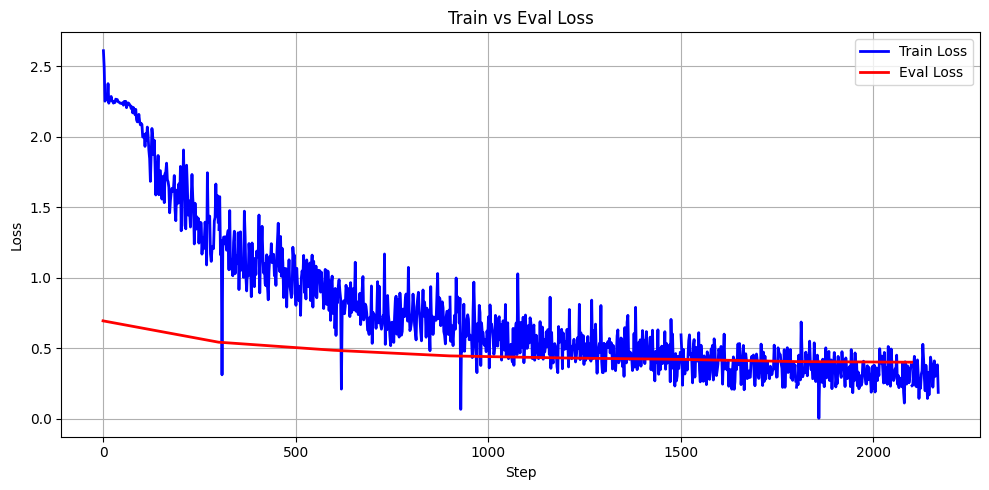

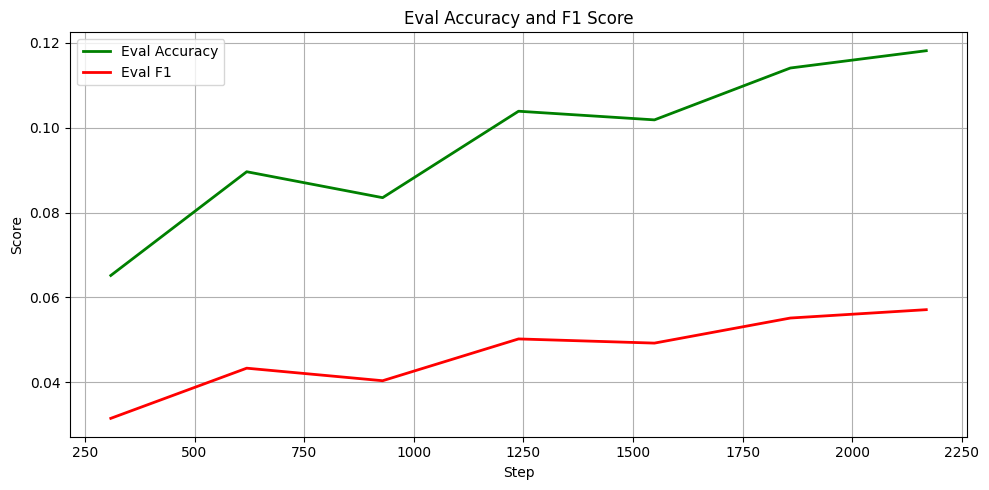

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd

if "train_loss" in log_df.columns:
    plt.plot(log_df["step"], log_df["train_loss"], label="Train Loss", color="blue", linewidth=2)

if "eval_loss" in log_df.columns:
    eval_df = log_df.dropna(subset=["eval_loss"])
    plt.plot(eval_df["step"], eval_df["eval_loss"], label="Eval Loss", color="red", linewidth=2)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Train vs Eval Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("log/plots/loss_curve_fixed.png")
plt.show()

plt.figure(figsize=(10, 5))
if "accuracy" in log_df.columns:
    acc_df = log_df.dropna(subset=["accuracy"])
    plt.plot(acc_df["step"], acc_df["accuracy"], label="Eval Accuracy", color="green", linewidth=2)
if "f1_score" in log_df.columns:
    f1_df = log_df.dropna(subset=["f1_score"])
    plt.plot(f1_df["step"], f1_df["f1_score"], label="Eval F1", color="red", linewidth=2)

plt.xlabel("Step")
plt.ylabel("Score")
plt.title("Eval Accuracy and F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("log/plots/accuracy_f1_curve.png")
plt.show()

In [ ]:
model_best = SimcseModel(pretrained_model=checkpoint, pooling='pooler', dropout=0.1).to(device)
model_best.load_state_dict(torch.load("saved_model/best_model.pt", map_location=device))
model_best.eval()

In [8]:
from dataset_Sim import TrainDataset, TestDataset, ClaimEvidenceEmbeddingDataset
from embed_evidence import embed_evidence, embed_evidence_pkl, load_evidence_embeddings_from_pickle
from model_Sim import SimcseModel, simcse_sup_loss, ClaimEvidenceClassifier
from train_Sim import load_train_data_supervised, train_sup, load_test_data_supervised
from embed_evidence import embed_evidence, embed_evidence_pkl, load_evidence_embeddings_from_pickle
from eval_train import match_evidence_by_similarity, varify_evidence
from train_classifier import train_classifier



import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import BertModel, BertConfig, BertTokenizer
from tqdm import tqdm

import pandas as pd
import json

In [7]:
batch_size = 16
max_length = 256
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

print(f"Using device: {device}")
checkpoint = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = SimcseModel(pretrained_model=checkpoint, pooling='pooler', dropout=0.1).to(device)
model.load_state_dict(torch.load("best_model_bt.pt", map_location=device))
model.eval()


Using device: cuda


SimcseModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [9]:
evidence_subset_path = "data/evidence_subset_train.json"
evidence_csv_path = "evidence_embed.json"
output_pkl_path = "evidence_embed.pkl"
embed_evidence_pkl(evidence_subset_path, output_pkl_path, model, tokenizer, device, max_length=256, batch_size=512)
evidence_embeddings_dict = load_evidence_embeddings_from_pickle(output_pkl_path, device)
evidence_ids = list(evidence_embeddings_dict.keys())
evidence_embeddings = torch.stack([evidence_embeddings_dict[eid]['embedding'] for eid in evidence_ids])  # [num_evidence, 768]


Save: total 3121 evidence save to evidence_embed.pkl


In [11]:
evidence_json_path = "data/dev-claims.json"

with open(evidence_json_path, "r", encoding="utf-8") as f:
    dev_claim = json.load(f)
results = []

for claim_id, claim_info in dev_claim.items():
    claim_text = claim_info["claim_text"]
    positive_ids = claim_info["evidences"]
    # Tokenize claim

    inputs = tokenizer(
        claim_text,
        max_length=256,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    with torch.no_grad():
        claim_embedding = model(input_ids, attention_mask, token_type_ids)

    # calculate cosine similarity for claim and all evidence
    sim_scores = F.cosine_similarity(claim_embedding, evidence_embeddings, dim=1)

    #sort top k evidence
    topk_probs, topk_indices = torch.topk(sim_scores, 5)
    output_evidence_id = [evidence_ids[i] for i in topk_indices]
    result = {
        "claim_id": claim_id,
        "claim_text": claim_text,
        "claim_label": claim_info["claim_label"],
        "top_evidence_ids": output_evidence_id
    }
    results.append(result)
with open("task2_input_Simcse.json", "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2, ensure_ascii=False)


# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

### Load or Use Trained Model for Retrieval and Classification

This step either loads a pretrained SimCSE model or uses the model trained in the previous step to perform evidence retrieval and classification. The process involves:

- Embedding all evidence texts using the trained encoder
- Encoding the input claim
- Computing similarity scores between the claim and all evidence embeddings
- Selecting top-ranked evidence based on similarity
- Optionally classifying the retrieved evidence as relevant or not using a trained classifier

In [12]:
%%capture
!pip install transformers accelerate

In [14]:
with open("task2_input_Simcse.json", "r", encoding="utf-8") as f:
    dev_claims = json.load(f)  # dict: id -> text

# with open("evidence-preprocessed3.json", "r", encoding="utf-8") as f:
#     evidence = json.load(f)  # dict: id -> text

with open("data/evidence.json", "r", encoding="utf-8") as f:
    evidence = json.load(f)  # dict: id -> text

In [15]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model_name = "Qwen/Qwen1.5-1.8B"
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
# model_name = "microsoft/phi-1.5"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).to(device).eval()

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [16]:
def load_dev_claims(dev_claims):
    return [
        {
            "claim_id": claim["claim_id"],
            "claim_text": claim["claim_text"],
            "claim_label": claim["claim_label"],
            "evidences": [evidence for evidence in claim["top_evidence_ids"] if evidence in evidence]
        }
        for claim in dev_claims
    ]


def build_prompt(claim, evidences):
    few_shot = """
You are a fact-checking assistant. Based on the claim and its evidence(s), classify the claim into one of the following categories: {SUPPORTS, REFUTES, NOT_ENOUGH_INFO, DISPUTED}.
Return format: Label: <label>

If previous evidence contradicts current evidence, classify the claim as DISPUTED.
If all evidence not relevant to the claim, classify the claim as NOT_ENOUGH_INFO.
"""
    ev_lines = "\n".join([f"Evidence {i+1}: {ev}" for i, ev in enumerate(evidences)])
    return few_shot.strip() + f"\n\nClaim: {claim}\n{ev_lines}\nLabel:"


import re

VALID_LABELS = ["SUPPORTS", "REFUTES", "NOT_ENOUGH_INFO", "DISPUTED"]

def normalize_label(label):
    label = label.upper()
    if re.match(r"SUPPORT", label):
        return "SUPPORTS"
    elif re.match(r"REFUTE", label):
        return "REFUTES"
    elif re.match(r"NOT[_\s]?ENOUGH[_\s]?INFO", label):
        return "NOT_ENOUGH_INFO"
    elif re.match(r"DISPUT", label):
        return "DISPUTED"
    else:
        return label

def extract_first_valid_label(text):
    matches = re.findall(r"Label:\s*([A-Za-z_ ]+)", text)
    for raw in matches:
        normalized = normalize_label(raw.strip())
        if normalized in VALID_LABELS:
            return normalized
    return "NOT_ENOUGH_INFO"  # fallback

def predict_qwen_causal(claim, evidences):
    prompt = build_prompt(claim, evidences)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=20,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id
    )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    label = extract_first_valid_label(decoded)
    return label

In [17]:
match = 0
total = 0
results={}


for claim in load_dev_claims(dev_claims):
    print(f'in {claim}')
    eid = claim["claim_id"]
    print(f'eid {eid}')
    claim_text = claim["claim_text"]
    claim_label = claim["claim_label"]
    evidences_text = [evidence[eid] for eid in claim["evidences"]]
    pred_label = predict_qwen_causal(claim_text, evidences_text)
    if pred_label not in ["SUPPORTS", "REFUTES", "NOT_ENOUGH_INFO", "DISPUTED"]:
        print(f"Invalid label: {pred_label}")
        pred_label = "SUPPORTS"
    results[eid] = {
        "claim_text": claim_text,
        "claim_label": pred_label,
        "evidences": claim["evidences"]
    }
    print(f'out {results[eid]}')
    if pred_label == claim_label:
        match += 1
    total += 1

print(f"Accuracy: {match / total:.4f}" if total > 0 else "No claims to evaluate.")

with open("task2_output_Lama_simcse_np.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

in {'claim_id': 'claim-752', 'claim_text': '[South Australia] has the most expensive electricity in the world.', 'claim_label': 'SUPPORTS', 'evidences': ['evidence-207013', 'evidence-1208472', 'evidence-886916', 'evidence-55060', 'evidence-984053']}
eid claim-752
out {'claim_text': '[South Australia] has the most expensive electricity in the world.', 'claim_label': 'DISPUTED', 'evidences': ['evidence-207013', 'evidence-1208472', 'evidence-886916', 'evidence-55060', 'evidence-984053']}
in {'claim_id': 'claim-375', 'claim_text': 'when 3 per cent of total annual global emissions of carbon dioxide are from humans and Australia prod\xaduces 1.3 per cent of this 3 per cent, then no amount of emissions reductio\xadn here will have any effect on global climate.', 'claim_label': 'NOT_ENOUGH_INFO', 'evidences': ['evidence-1101862', 'evidence-795384', 'evidence-517070', 'evidence-998171', 'evidence-465614']}
eid claim-375
out {'claim_text': 'when 3 per cent of total annual global emissions of car